In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import classification_report

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 4
IMG_SIZE = 128
NUM_CLASSES = 2
EPSILON = 0.03
PGD_STEPS = 7

In [3]:
# --- Adversarial Attack Functions ---
def fgsm_attack(model, images, labels, epsilon=EPSILON):
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed = images + epsilon * images.grad.sign()
    return torch.clamp(perturbed, 0, 1).detach()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=0.01, iters=PGD_STEPS):
    perturbed = images.clone().detach()
    for _ in range(iters):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed += alpha * perturbed.grad.sign()
            perturbed = torch.max(torch.min(perturbed, images + epsilon), images - epsilon)
            perturbed = torch.clamp(perturbed, 0, 1)
    return perturbed.detach()

def one_pixel_attack(images, pixel_count=1):
    perturbed = images.clone()
    batch_size, _, h, w = images.shape
    for i in range(batch_size):
        for _ in range(pixel_count):
            x, y = np.random.randint(0, h), np.random.randint(0, w)
            perturbed[i, :, x, y] = torch.rand(3)
    return perturbed

In [4]:
# --- Robust Model Architecture ---
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std
        
    def forward(self, x):
        return x + torch.randn_like(x) * self.std if self.training else x

class RobustHybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Input processing
        self.input_norm = nn.BatchNorm2d(3)
        self.input_denoiser = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1)
        )
        
        # CNN backbone
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            GaussianNoise(0.05),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Transformer
        self.patch_embed = nn.Conv2d(256, 128, kernel_size=4, stride=4)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=4, dim_feedforward=256),
            num_layers=2
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.input_norm(x)
        x = self.input_denoiser(x)
        x = self.cnn(x)
        x = self.patch_embed(x)
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.classifier(x)

In [ ]:
# --- Adversarial Training Loop ---
def robust_train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0, 0
    for x, y in tqdm(loader, desc="Training"):
        x, y = x.to(device), y.to(device)
        
        # Generate adversarial examples
        with torch.enable_grad():
            x_fgsm = fgsm_attack(model, x, y)
            x_pgd = pgd_attack(model, x, y)
        
        x_pixel = one_pixel_attack(x)
        
        # Combined training batch
        mixed_x = torch.cat([x, x_fgsm, x_pgd, x_pixel])
        mixed_y = torch.cat([y]*4)
        
        optimizer.zero_grad()
        outputs = model(mixed_x)
        loss = criterion(outputs, mixed_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        correct += (outputs.argmax(1) == mixed_y).sum().item()
    
    acc = correct / (4 * len(loader.dataset))
    return running_loss / len(loader), acc


In [6]:
# --- Evaluation with Attacks ---
def adversarial_test(model, loader):
    model.eval()
    results = {'clean': {'correct': 0, 'total': 0},
               'fgsm': {'correct': 0, 'total': 0},
               'pgd': {'correct': 0, 'total': 0},
               'pixel': {'correct': 0, 'total': 0}}
    
    for x, y in tqdm(loader, desc="Testing"):
        x, y = x.to(device), y.to(device)
        
        # Clean samples
        with torch.no_grad():
            out_clean = model(x)
        results['clean']['correct'] += (out_clean.argmax(1) == y).sum().item()
        results['clean']['total'] += y.size(0)
        
        # Generate attacks
        with torch.enable_grad():
            x_fgsm = fgsm_attack(model, x, y)
            x_pgd = pgd_attack(model, x, y)
        x_pixel = one_pixel_attack(x)
        
        # Test attacks
        with torch.no_grad():
            for name, data in [('fgsm', x_fgsm), ('pgd', x_pgd), ('pixel', x_pixel)]:
                out = model(data)
                results[name]['correct'] += (out.argmax(1) == y).sum().item()
                results[name]['total'] += y.size(0)
    
    # Calculate accuracies
    metrics = {}
    for key in results:
        metrics[key] = results[key]['correct'] / results[key]['total']
    return metrics


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [8]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train', transform=transform)
test_dataset = datasets.ImageFolder('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test', transform=transform)

# Remap targets: FAKE=1, REAL=0
for dataset in [train_dataset, test_dataset]:
    dataset.targets = [1 if x == dataset.class_to_idx['FAKE'] else 0 for x in dataset.targets]

In [10]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)


Epoch 1/1


Training: 100%|██████████| 1563/1563 [53:19<00:00,  2.05s/it]


Train Loss: 0.6310, Train Acc: 0.6171


Testing: 100%|██████████| 313/313 [07:52<00:00,  1.51s/it]



Adversarial Performance:
CLEAN  Accuracy: 79.81%
FGSM   Accuracy: 54.47%
PGD    Accuracy: 52.33%
PIXEL  Accuracy: 79.81%

Final Test Results:


Testing: 100%|██████████| 313/313 [07:09<00:00,  1.37s/it]


CLEAN  Accuracy: 79.81%
FGSM   Accuracy: 54.47%
PGD    Accuracy: 52.33%
PIXEL  Accuracy: 79.80%


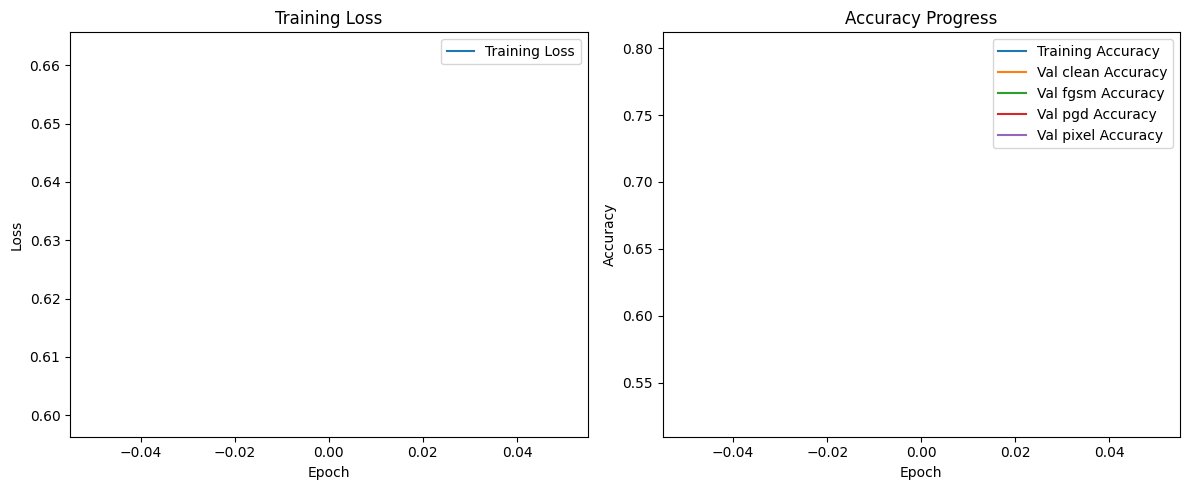

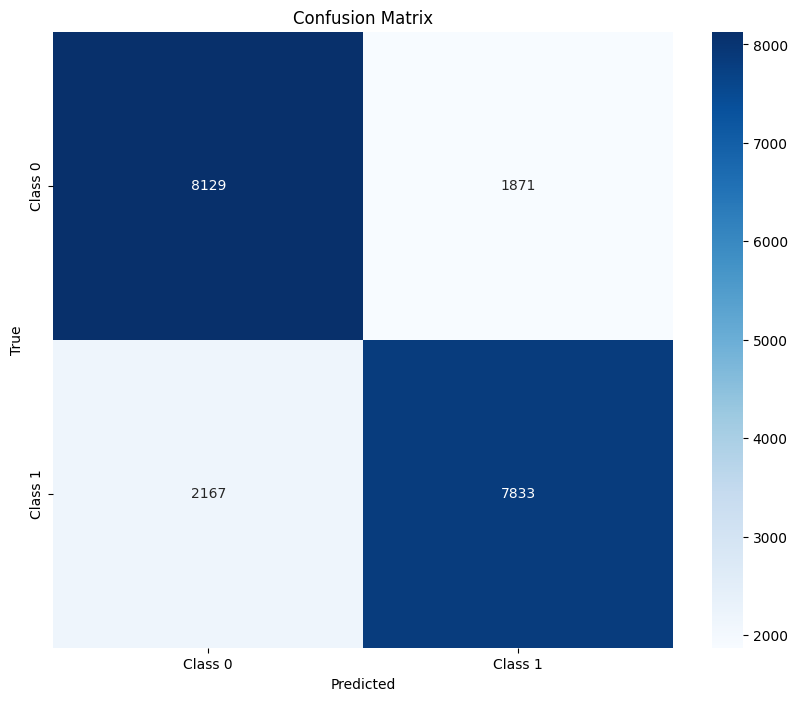

Model saved to robust_hybrid_cifake.pth


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import defaultdict

# Assuming you have these defined elsewhere
# from your_model import RobustHybridModel
# from your_data_loading import train_loader, test_loader

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
EPOCHS = 1

# Initialize model, optimizer, and criterion
model = RobustHybridModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Initialize tracking variables
train_losses = []
train_accuracies = []
val_metrics = defaultdict(list)  # Will store metrics for each attack type

def plot_training_curves(train_losses, train_accuracies, val_metrics):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))
    
    # Plot training loss and accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    for attack, accs in val_metrics.items():
        plt.plot(accs, label=f'Val {attack} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Progress')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

def plot_confusion_matrix(model, data_loader, device):
    """Generate and plot confusion matrix."""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

# Training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Training phase
    train_loss, train_acc = robust_train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    # Periodic evaluation
    if (epoch+1) % 2 == 0 or epoch == EPOCHS - 1:
        metrics = adversarial_test(model, test_loader)
        print("\nAdversarial Performance:")
        for attack, acc in metrics.items():
            print(f"{attack.upper():<6} Accuracy: {acc:.2%}")
            val_metrics[attack].append(acc)
        
        # Plot training curves every 5 epochs
        if (epoch+1) % 5 == 0:
            plot_training_curves(train_losses, train_accuracies, val_metrics)

# Final Evaluation
print("\nFinal Test Results:")
metrics = adversarial_test(model, test_loader)
for attack, acc in metrics.items():
    print(f"{attack.upper():<6} Accuracy: {acc:.2%}")

# Generate final plots
plot_training_curves(train_losses, train_accuracies, val_metrics)
plot_confusion_matrix(model, test_loader, device)

# Save Model
torch.save(model.state_dict(), "robust_hybrid_cifake.pth")
print("Model saved to robust_hybrid_cifake.pth")